Using cache found in C:\Users\maxan/.cache\torch\hub\pytorch_vision_v0.10.0


successfully loaded model checkpoint from model_saves\ThickerTextInLabels_Test29_55465546.pytorch_model


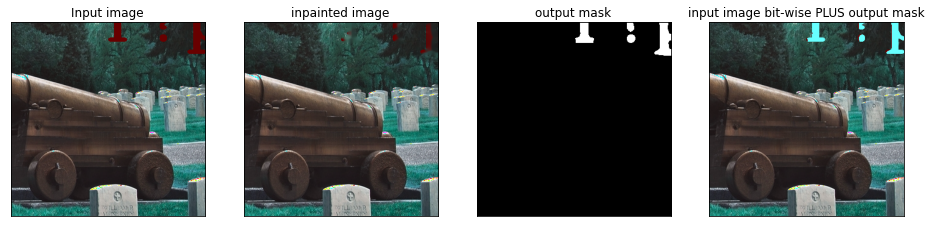

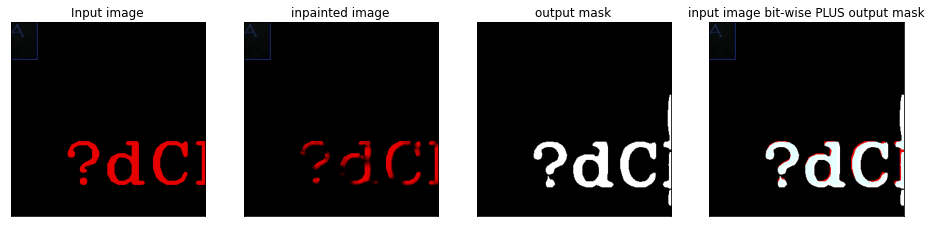

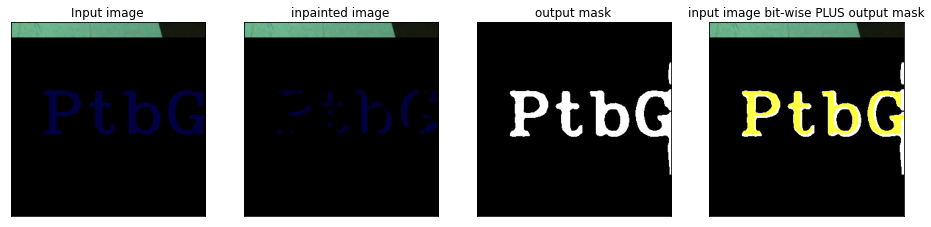

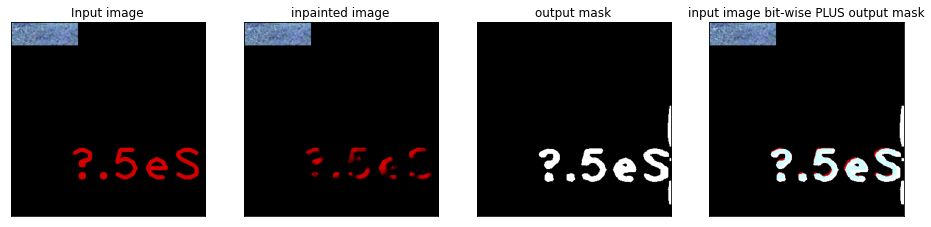

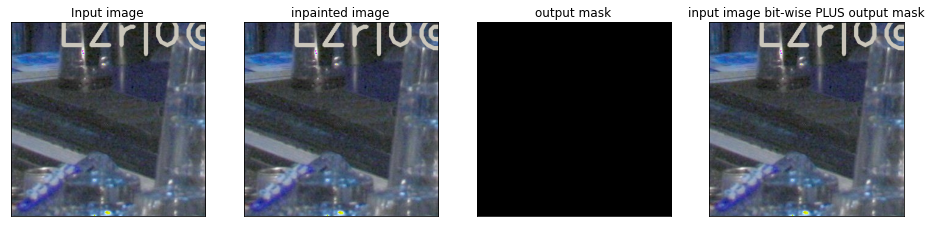

In [1]:
import numpy as np
import cv2 as cv
from torch.utils.data import DataLoader
from generate_training_validation_data import CustomImageDataset
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms


model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True, )
optimizer = optim.Adam(model.parameters(), lr=6.630131189647407e-07, betas=(0.006967112069996084, 0.9853718852556564), eps=10**-7) # decided by 5 trials (epochs) of hyperparameter tuning with Optuna

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

model.classifier[4] = torch.nn.Conv2d(512, 2, kernel_size=(1,1), stride = (1,1))
model.aux_classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=(1,1), stride = (1,1))

train_data_dir = 'D:/MemeMachine_ProjectData/dataset/training'
validation_data_dir = 'D:/MemeMachine_ProjectData/dataset/validation'
img_width, img_height, n_channels = 320, 320, 3 

train_dataset = CustomImageDataset(train_data_dir, img_width, img_height)
test_dataset = CustomImageDataset(validation_data_dir, img_width, img_height)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)


path = "model_saves\ThickerTextInLabels_Test29_55465546.pytorch_model"
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

print("successfully loaded model checkpoint from", path)

model.eval()

for i in range (5):

    # Display image and label
    inputs, _ = next(iter(train_dataloader))

    inputs = inputs.squeeze()
    inputs = np.moveaxis(inputs.detach().cpu().numpy(), 0, -1)
    preprocessed_inputs = cv.cvtColor(inputs, cv.COLOR_BGR2RGB)
    preprocessed_inputs = Image.fromarray(np.uint8(preprocessed_inputs))
    preprocessed_inputs = preprocessed_inputs.convert("RGB")
    preprocessed_inputs = preprocess(preprocessed_inputs)
    preprocessed_inputs = preprocessed_inputs.unsqueeze(0)
    inputs = (inputs*256).astype(np.uint8)


    output = model(preprocessed_inputs)['aux'][0]
    output = nn.Softmax(dim=0)(output)
    output = output[1] - output[0]
    output = torch.unsqueeze(output, -1).detach().numpy()
    output[output<=0] = 0
    output[output>0] = 1
    output = output.astype(np.uint8)

    fig = plt.figure(figsize=(16, 8))
    
    fig.add_subplot(1, 4, 1, xticks=[], yticks=[])
    plt.title("Input image")
    plt.imshow(inputs, cmap="gray")
    
    fig.add_subplot(1, 4, 2, xticks=[], yticks=[])
    plt.title("inpainted image")
    dst = cv.inpaint(inputs,output,3,cv.INPAINT_TELEA)
    plt.imshow(dst, cmap="gray")

    fig.add_subplot(1, 4, 3, xticks=[], yticks=[])
    plt.title("output mask")
    plt.imshow(output, cmap='gray')

    fig.add_subplot(1, 4, 4, xticks=[], yticks=[])
    plt.title("input image bit-wise PLUS output mask")
    xor_image = inputs
    xor_image[:,:,0] = np.squeeze(255*output) +  xor_image[:,:,0]
    xor_image[:,:,1] = np.squeeze(255*output) +  xor_image[:,:,1]
    xor_image[:,:,2] = np.squeeze(255*output) +  xor_image[:,:,2]

    
 

    plt.imshow(xor_image, cmap='gray')


    fig.savefig("cv2inpainting_telea/Test28Modelimage_"+str(i)+".jpg", dpi='figure')

In [2]:
xor_image = inputs
xor_image[:,:,0] = np.squeeze(255*output)
xor_image[:,:,0] = np.squeeze(255*output)
xor_image[:,:,0] = np.squeeze(255*output)

square_output = np.reshape(output, xor_image.shape[0:2])
print(square_output.shape)
# print(square_output[square_output==1].shape)
print(xor_image[:,:,0].shape)


print(xor_image)

(320, 320)
(320, 320)
[[[  0  76 101]
  [  0  80 105]
  [  0  83 108]
  ...
  [  0  57  68]
  [  0  55  66]
  [  0  53  64]]

 [[  0  71  94]
  [  0  74  97]
  [  0  77 104]
  ...
  [  0  55  69]
  [  0  54  66]
  [  0  54  65]]

 [[  0  65  88]
  [  0  68  91]
  [  0  72 100]
  ...
  [  0  59  71]
  [  0  57  72]
  [  0  58  72]]

 ...

 [[  0 104 123]
  [  0 103 122]
  [  0 101 120]
  ...
  [  0  80  84]
  [  0  81  85]
  [  0  81  87]]

 [[  0 104 124]
  [  0 104 124]
  [  0 101 121]
  ...
  [  0  84  90]
  [  0  87  93]
  [  0  83  91]]

 [[  0 103 122]
  [  0 105 124]
  [  0 101 120]
  ...
  [  0  86  93]
  [  0  88  97]
  [  0  86  95]]]
